In [ ]:
# Importando bibliotecas
import pandas as pd
import seaborn as sn
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
# Ler base de dados
df = pd.read_stata('salario_ stata 11.dta')

In [48]:
# Convertendo tipos e visualizando dados
df = df.astype({
    'DummyMulher': 'int8',
    'Posgrad': 'int8'
})
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Sal          10 non-null     int8 
 1   Exp          10 non-null     int8 
 2   CursoCap     10 non-null     int8 
 3   DummyMulher  10 non-null     int8 
 4   Posgrad      10 non-null     int8 
dtypes: int8(5)
memory usage: 182.0 bytes


,Sal,Exp,CursoCap,DummyMulher,Posgrad
0,15,8,0,0,1
1,20,6,1,0,2
2,20,15,0,0,2
3,40,20,1,1,3
4,50,25,2,1,3
5,25,11,1,0,2
6,10,5,0,0,1
7,55,32,3,1,1
8,35,28,1,0,2
9,30,20,1,0,2


In [49]:
# Resultados do modelo de regressão
fit = smf.ols('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    Sal   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     374.9
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           2.22e-06
Time:                        21:22:08   Log-Likelihood:                -12.146
No. Observations:                  10   AIC:                             34.29
Df Residuals:                       5   BIC:                             35.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.3996      1.282      4.211      

/home/herick/mqa_trabalhos/aplicacoes_MCRL/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


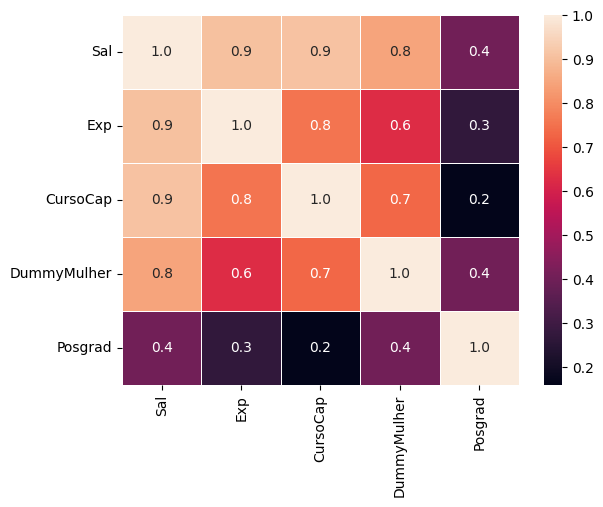

In [50]:
# Matriz de correlação
correlation = df.corr()

# plot da matriz de correlação
plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)

Teste de multicolinearidade

In [51]:
# Definindo o modelo para cálculo do VIF (Teste de Multicolinearidade)

# Run a multiple regression
y, X = dmatrices('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', df, return_type='dataframe')

# Calculate VIF Factors
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [52]:
# Visualizar VIF Factors
vif.round(1)

,VIF Factor,features
0,12.4,Intercept
1,2.5,Exp
2,3.4,CursoCap
3,2.7,DummyMulher
4,1.3,Posgrad


In [53]:
# Teste Breusch-Pagan (Teste de heterocedasticidade)

# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(fit.resid, fit.model.exog)
 
lzip(names, test_result)

[('Lagrange multiplier statistic', np.float64(7.225700545029373)),
 ('p-value', np.float64(0.12443095114703495)),
 ('f-value', np.float64(3.255641947773206)),
 ('f p-value', np.float64(0.11377236945953488))]

In [55]:
# Teste Breusch-Godfrey

#perform Breusch-Godfrey test at order p = 3
print(dg.acorr_breusch_godfrey(fit, nlags=3))

(np.float64(7.370252415759586), np.float64(0.06098763502216598), 1.8684308866569896, 0.36726254596915)
